In [2]:
# load functions
import numpy as np
import pandas as pd
import random
import seaborn as sns 
import os
import forestplot as fp
import re

random.seed(7)

from src.utils import get_data, get_nn_output
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sksurv.metrics import concordance_index_censored
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from functools import reduce
from lifelines import CoxPHFitter
from statsmodels.api import OLS, Logit, add_constant
from statsmodels.stats.weightstats import ztest
from scipy.stats import norm, wilcoxon, shapiro

/tmp/ipykernel_3920949/4176998047.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# Results bootstrap - significance

In [3]:
def check_significance(array1, array2):
    # Check normality of the differences
    differences = array1 - array2
    stat, p_value_normality = shapiro(differences)
    if p_value_normality > 0.05:
        print("Differences are normally distributed. Using Z-test.")
        stats, p_value = ztest(array1, array2, value=0, usevar='unequal') 
    else:
        print("Differences are not normally distributed. Using Wilcoxon signed-rank test.")
        stats, p_value = wilcoxon(array1, array2)
    if p_value < 0.05:
        print("The performance metrics are significantly different.")
    else:
        print("No significant difference in performance metrics.")
    return(stats, p_value)


In [4]:
#load bootstrap elastic net
#Frailty
ft_allprot_en = np.load('output_linear/bootstrap/frailty/keep_metric_frailty_allprot_own_size.npy')[:,1]
ft_cmb_en = np.load('output_linear/bootstrap/frailty/keep_metric_frailty_cmb_own_size.npy')[:,1]
ft_cmb_ffs_en = np.load('output_linear/bootstrap/frailty/keep_metric_frailty_cmb_ffs_own_size.npy')[:,1]
#Mortality
mort_allprot_en = np.load('output_linear/bootstrap/mort/metric_mort_allprot_own_size.npy')[:,1]
mort_cmb_en = np.load('output_linear/bootstrap/mort/metric_mort_cmb_own_size.npy')[:,1]
mort_cmb_ffs_en = np.load('output_linear/bootstrap/mort/metric_mort_cmb_ffs_own_size.npy')[:,1]

#FNN
#Frailty
ft_allprot_fnn = pd.read_csv('intermediate_results/NN_Allprot_frailty_bootstrap.csv')['r2_val'].values

#Mortality
mort_allprot_fnn = pd.read_csv('intermediate_results/NN_Allprot_mort_bootstrap.csv')['concordance_val'].values

In [6]:
diff = mort_allprot_en - mort_allprot_fnn
d = diff.mean()
D = 0 
var1 = mort_allprot_en.var()
var2 = mort_allprot_fnn.var()
n = 100

zpaired = (d-D)/((var1+var2)/(n-1))**0.5

In [7]:
zpaired

15.822101615496871

In [8]:
#FNN vs EN
#allprot
print(check_significance(ft_allprot_en, ft_allprot_fnn))
print(check_significance(mort_allprot_en, mort_allprot_fnn))

Differences are normally distributed. Using Z-test.
The performance metrics are significantly different.
(47.61432918781029, 0.0)
Differences are normally distributed. Using Z-test.
The performance metrics are significantly different.
(15.822101615496827, 2.1905679165574586e-56)


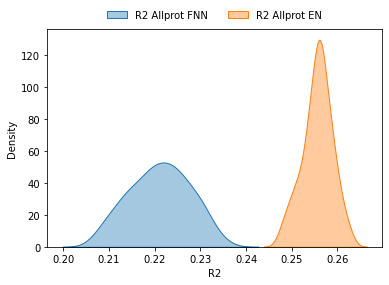

<Figure size 432x288 with 0 Axes>

In [9]:
allprotfnn = pd.DataFrame({'R2':ft_allprot_fnn, 'Metric':"R2 Allprot FNN"})
allproten = pd.DataFrame({'R2':ft_allprot_en, 'Metric':"R2 Allprot EN"})
difsdf = pd.concat([allprotfnn, allproten])
difplot = sns.kdeplot(data=difsdf, x="R2", hue="Metric", fill=True, common_norm=False, alpha=0.4)
sns.move_legend(
    difplot, "lower center",
    bbox_to_anchor=(.5, 1), ncol=4, title=None, frameon=False,
)
plt.show()
plt.savefig('.png')

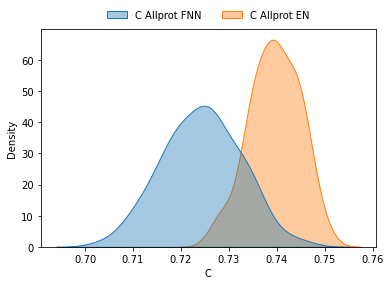

In [10]:
allprotfnn = pd.DataFrame({'C':mort_allprot_fnn, 'Metric':"C Allprot FNN"})
allproten = pd.DataFrame({'C':mort_allprot_en, 'Metric':"C Allprot EN"})
difsdf = pd.concat([allprotfnn, allproten])
difplot = sns.kdeplot(data=difsdf, x="C", hue="Metric", fill=True, common_norm=False, alpha=0.4)
sns.move_legend(
    difplot, "lower center",
    bbox_to_anchor=(.5, 1), ncol=4, title=None, frameon=False,
)
plt.show()

In [28]:
def densityplot(array1, array2, name1, name2, custom_palette):
    df1 = pd.DataFrame({'Metric':array1, 'Biomarker':name1})
    df2 = pd.DataFrame({'Metric':array2, 'Biomarker':name2})
    difsdf = pd.concat([df2, df1])
    difplot = sns.kdeplot(data=difsdf, x="Metric", hue="Biomarker", fill=True, common_norm=False, alpha=0.6, palette = custom_palette)
    sns.move_legend(
        difplot, "lower center",
        bbox_to_anchor=(.5, 1), ncol=4, title=None, frameon=False,
    )
    plt.show()

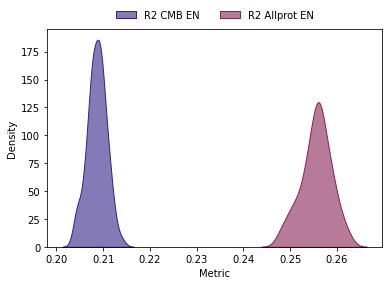

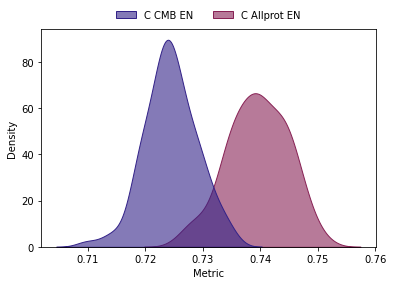

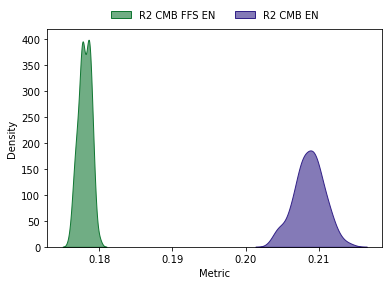

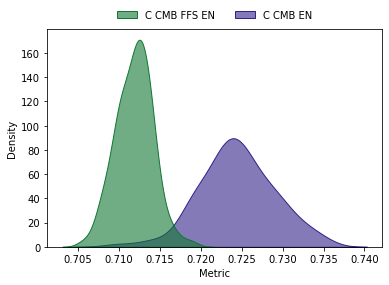

In [31]:
custom_palette = ['#88CCEE', '#44AA99', '#117733', '#332288', '#DDCC77', '#999933','#CC6677', '#882255', '#AA4499', '#DDDDDD']
custom_palette1 = ['#332288', '#882255']
custom_palette2 = ['#117733','#332288']

densityplot(ft_allprot_en, ft_cmb_en, 'R2 Allprot EN', 'R2 CMB EN', custom_palette1)
densityplot(mort_allprot_en, mort_cmb_en, 'C Allprot EN', 'C CMB EN', custom_palette1)

densityplot(ft_cmb_en, ft_cmb_ffs_en, 'R2 CMB EN', 'R2 CMB FFS EN', custom_palette2)
densityplot(mort_cmb_en, mort_cmb_ffs_en, 'C CMB EN', 'C CMB FFS EN', custom_palette2)

In [24]:
#Check significance
print(check_significance(ft_allprot_en, ft_cmb_en))
print(check_significance(ft_cmb_en, ft_cmb_ffs_en))
print(check_significance(mort_allprot_en, mort_cmb_en))
check_significance(mort_cmb_en, mort_cmb_ffs_en)

Differences are normally distributed. Using Z-test.
The performance metrics are significantly different.
(123.1440019900758, 0.0)
Differences are normally distributed. Using Z-test.
The performance metrics are significantly different.
(138.92381984647918, 0.0)
Differences are normally distributed. Using Z-test.
The performance metrics are significantly different.
(21.695180150405267, 2.2783099148493932e-104)
Differences are normally distributed. Using Z-test.
The performance metrics are significantly different.


(24.71011388499016, 8.326876028746536e-135)

# Load data

In [25]:
_, set3prots, _, set3eidsall = get_data({'dset': 'cmb', 'target': 'mort', 'add_age':0, 'combine_sets':True})
_, _, _, _, _, _, colscmb = get_data({'dset': 'cmb', 'target': 'mort', 'add_age':0, 'combine_sets':False})
set3_df = pd.DataFrame(set3eidsall, columns = ['eid'], index = set3eidsall)
set3_df

,eid
5527725,5527725
5527748,5527748
5527912,5527912
5528264,5528264
5528503,5528503
...,...
5323166,5323166
3026334,3026334
4775604,4775604
2041221,2041221


## Elastic nets

In [26]:
def calculate_biomarkers(protein_df, coefficients_df, name_col, weight_col):
    # Map proteins to coefficients (protein names are keys, coefficients are values)
    coefficient_dict = coefficients_df.set_index(name_col)[weight_col].to_dict()
    
    # Identify the common proteins
    common_proteins = protein_df.columns.intersection(coefficient_dict.keys())
    
    # Multiply protein by weight
    weighted_values = protein_df[common_proteins].mul([coefficient_dict[protein] for protein in common_proteins], axis=1)
    
    # Create sumscore
    sumscore = weighted_values.sum(axis=1)
    
    return sumscore

In [27]:
def make_pandas_from_data(dset, target):
    _, set3prots, _, set3eids = get_data({'dset': dset, 'target': target, 'add_age':0, 'combine_sets':True})
    _, _, _, _, _, _, cols = get_data({'dset': dset, 'target': target, 'add_age':0, 'combine_sets':False})
    pandasframe = pd.DataFrame(set3prots[0], columns = cols[:-1], index = set3eids)
    pandasframe['eid'] = pandasframe.index
    return pandasframe

In [28]:
def process_en_models(directory, target, set3_df):
    # Loop through selected models directory
    for file in os.listdir(directory):
        if file.endswith(".csv"):
            file_name = os.path.splitext(file)[0]  # remove .csv
            file_path = os.path.join(directory, file)
            weights_df = pd.read_csv(file_path)  # Load the weights DataFrame

            # Find the dset using regular expression
            match = re.search(rf'{target}_(.*?)_?(?:ffs)?$', file_name)
            if match:
                # Call function to create pandas DataFrame from the model type and matched group
                set3_model = make_pandas_from_data(match.group(1), target)
                set3_model[file_name] = calculate_biomarkers(set3_model, weights_df, weights_df.columns[0], weights_df.columns[1])

                # Merge with set3_df
                set3_df = pd.merge(set3_df, set3_model[['eid', file_name]], on='eid', how='outer')
            else:
                print(f'Not the right way to do this, error is for {target} and {file_name}!')
    return set3_df

In [29]:
# frailty_en_directory = os.path.join('output_linear/coefs_frail/selected_models/')
# a = os.listdir(frailty_en_directory)[0]
# file_name = os.path.splitext(a)[0]
# file_name

# file_path = os.path.join(frailty_en_directory, a)
# weights_df = pd.read_csv(file_path)  # Load the weights DataFrame
# match = re.search(rf'{'frailty'}_(.*?)_?(?:ffs)?$', file_name)
# match.group(1)

In [30]:
#Elastic net biomarkers
frailty_en_directory = os.path.join('output_linear/coefs_frail/selected_models/')
mort_en_directory = os.path.join('output_linear/coefs_mort/selected_models/')
set3_df = process_en_models(frailty_en_directory, 'frailty', set3_df)
set3_df = process_en_models(mort_en_directory, 'mort', set3_df)
set3_df.index = set3_df['eid']
set3_df.drop('eid', axis =1, inplace=True)
set3_df.columns = set3_df.columns.str.removeprefix("combine_")

## Neural nets

In [31]:
# Get set and give column right name for joining
def assign_nn_out(dataset_type, target, model_path):
    _, data_array,_,eids = get_data({'dset': dataset_type, 'target': target, 'combine_sets':True})
    var_name = f'nn_pred_{dataset_type}_{target}'
    df = get_nn_output(data_array[0], model_path, dataset_type, target, data_index = eids)
    df.columns = [f'nn_{dataset_type}_{target}']
    globals()[var_name] = df

In [32]:
#Neural net biomarkers
#Mortalty
assign_nn_out('allprot', 'mort', "nn_models/model_pun3hzmh.pt")
assign_nn_out('cmb', 'mort', "nn_models/model_i4uflnuh.pt")
#assign_nn_pred('cmb_met', 'ds_default', 'mort', "nn_models/model_10gcjcfu.pt")
assign_nn_out("cmb_ffs", "mort", "nn_models/model_77k50cmg.pt")
#assign_nn_pred("cmb_met_ffs", "ds_default", "mort", "nn_models/model_imcrwxzr.pt")
# assign_nn_pred("allprot_ffs", "ds_default", "mort",  "nn_models/model_.pt")
#  still need,  FFS (3x) cluster bootstrap; filepaths probably need updates

#Frailty
assign_nn_out('allprot', 'frailty', "nn_models/model_m2526gyz.pt")
assign_nn_out('cmb', 'frailty', "nn_models/model_qjtdn71n.pt")
#assign_nn_pred('cmb_met', 'ds_default', 'frailty', "nn_models/model_em48t350.pt")
assign_nn_out("cmb_ffs", "frailty", "nn_models/model_dbwxpwou.pt")
#assign_nn_pred("cmb_met_ffs", "ds_default", "frailty", "nn_models/model_sk9pmzkq.pt")
#assign_nn_pred("allprot_ffs", "ds_default", "frailty", "nn_models/model_r5fp41b9.pt") 

In [33]:
# Merge mortality and frailty datasets then combine
nn_pred_cmb_mortality = reduce(lambda left, right: pd.merge(left, right, left_index=True, right_index=True, how='outer'), 
                               [v for k, v in globals().items() if k.startswith('nn_') and k.endswith('_mort')])
nn_pred_cmb_frailty = reduce(lambda left, right: pd.merge(left, right, left_index=True, right_index=True, how='outer'), 
                             [v for k, v in globals().items() if k.startswith('nn_') and k.endswith('_frailty')])
nn_combined_data = pd.merge(nn_pred_cmb_mortality, nn_pred_cmb_frailty, left_index=True, right_index=True, how='outer')

In [34]:
nn_combined_data.shape

(4071, 6)

In [35]:
nn_pred_cmb_frailty.head()

,nn_allprot_frailty,nn_cmb_frailty,nn_cmb_ffs_frailty
1001997,0.115135,0.121484,0.137884
1002479,0.109603,0.094470,0.096958
1004484,0.108492,0.108581,0.109894
1007135,0.126425,0.103599,0.138024
1009298,0.142709,0.167796,0.149413


In [36]:
nn_pred_cmb_frailty.shape

(4068, 3)

In [37]:
_, set3, _, set3eids = get_data({'dset': 'cmb', 'target': 'frailty', 'add_age':1, 'combine_sets':True})
set3_ft = pd.DataFrame(set3[1], index = set3eids, columns = ['frailty'])
set3_ft = set3_ft.merge(nn_pred_cmb_frailty, left_index = True, right_index = True)


In [38]:
set3_ft.head()

,frailty,nn_allprot_frailty,nn_cmb_frailty,nn_cmb_ffs_frailty
5527725,0.107143,0.114303,0.122934,0.116432
5527748,0.147959,0.150886,0.209146,0.154727
5527912,0.079592,0.114708,0.119481,0.113072
5528264,0.043878,0.101080,0.090472,0.098392
5528503,0.150000,0.104922,0.105851,0.108091


In [39]:
#set 3 r2 scores
cmb_r2_set3 = r2_score(set3_ft['frailty'].values, set3_ft['nn_cmb_frailty'].values)
allprot_r2_set3 = r2_score(set3_ft['frailty'].values, set3_ft['nn_allprot_frailty'].values)
cmb_ffs_r2_set3 = r2_score(set3_ft['frailty'].values, set3_ft['nn_cmb_ffs_frailty'].values)


In [40]:
cmb_r2_set3, allprot_r2_set3, cmb_ffs_r2_set3

(0.22647126051488853, 0.2198198858940652, 0.20344574897858358)

## Other biomarkers

In [41]:
pac = pd.read_csv('Data/Other_Biomarkers/pac_set3.csv', index_col = 'eid')
pac.head()

,PAC
eid,
1001997,48.512295
1002479,44.823446
1021769,47.131362
1062421,44.092066
1065061,55.477987


In [42]:
gadd = pd.read_csv('Data/Other_Biomarkers/Gadd_biomarkers.csv', index_col = 'eid')
pac = pd.read_csv('Data/Other_Biomarkers/pac_set3.csv', index_col = 'eid')
metabohealth = pd.read_csv('./Data/Other_Biomarkers/Round0_MiMIR_MetaboHealth.csv', index_col = 'eid')
metabohealth = metabohealth[metabohealth.index.isin(set3_df.index)]
metabohealth.dropna(how='any', inplace=True)
set3_proteins = pd.DataFrame(set3prots[0], columns = colscmb[:-1], index = set3eidsall)

## Demographics and lifestyle factors

In [43]:
#Age 
age = pd.read_csv('./Data/covar/basicinfo.csv', low_memory=False, index_col = 'eid') #age
age = age[['age_center.0.0']]
age = age.rename(columns={'age_center.0.0': 'age'})

#Mortality
set3_mort = pd.read_csv("Data/Processed/Full/mort_full_val.csv", index_col = 'eid') #differently named, chosen based on number of individuals

#Frailty
frailty_set3 = pd.read_csv('Data/endpoints/Frailty/frailty_clean_set3.csv', index_col = 'eid')

#Lifestyle
lifestyle = pd.read_csv('Data/covar/UKB_Lifestyle.csv', index_col = 'eid')
lifestyle = lifestyle[['ses.0.0', 'lymf.0.0', 'mono.0.0','bmi.0.0', 'smoking.0.0', 'smokingyn.0.0', 'smkfrq.0.0', 'alcperweek.0.0']]

#CVD
cvd = pd.read_csv('Data/endpoints/FollowUpCVD.csv', index_col = 'eid')

#Cancer
cancer = pd.read_csv('Data/endpoints/FollowUpCancer.csv', index_col = 'eid')

#Handgrip and selfperceived health
#Note: originally higher score on self perceived health means lower self perceived health but changed it for easier interpretability
hgsph = pd.read_csv('Data/endpoints/HandgripSelfperceived.csv', index_col = 'eid')
hgsph['poor_health'] = np.where(hgsph['self_perceived_health'].isin([0, 1]), 1, 0)
hgsph['poor_health'] = hgsph['poor_health'].where(hgsph['self_perceived_health'].notna(), np.nan)

#Basic info
basicinfo = pd.read_csv('Data/covar/basicinfo_instance_0.csv', index_col = 'eid')

In [44]:
hgsph['self_perceived_health'].describe()

count    4033.000000
mean        1.819737
std         0.747341
min         0.000000
25%         1.000000
50%         2.000000
75%         2.000000
max         3.000000
Name: self_perceived_health, dtype: float64

In [45]:
basicinfo.head()

,sex,died,age_center.0.0,date_center.0.0,hbp.0.0,smoking.0.0,yearbirth,monthbirth,mortdate.0.0,followup
eid,,,,,,,,,,
1000014,0.0,0,63.0,2008-09-13,1,0.0,1945.0,5.0,NaN,14.264203
1000023,0.0,0,57.0,2010-05-12,0,1.0,1953.0,3.0,NaN,12.605065
1000030,1.0,0,40.0,2007-10-18,0,0.0,1967.0,1.0,NaN,15.170431
1000041,1.0,0,65.0,2010-04-15,1,0.0,1944.0,11.0,NaN,12.678987
1000059,1.0,0,50.0,2008-08-06,0,0.0,1958.0,7.0,NaN,14.368241


In [46]:
age

,age
eid,
1000014,63.0
1000023,57.0
1000030,40.0
1000041,65.0
1000059,50.0
...,...
6024824,52.0
6024838,42.0
6024846,65.0


In [47]:
#Make one giant dataframe
dfs_to_merge = [set3_df, nn_combined_data, gadd, pac, metabohealth, set3_proteins['GDF15'], set3_mort, age, lifestyle, cvd, cancer, hgsph, basicinfo['hbp.0.0']]
compare_df = reduce(lambda left, right: pd.merge(left, right, left_index=True, right_index=True), dfs_to_merge)
compare_df.head()

,coefs_frailty_cmb_ffs,coefs_frailty_cmb,coefs_frailty_allprot,coefs_mort_allprot,coefs_mort_cmb,coefs_mort_cmb_ffs,nn_allprot_mort,nn_cmb_mort,nn_cmb_ffs_mort,nn_allprot_frailty,...,CVD_prev,CVD_inc,CVD_age,cancer_prev,cancer_inc,cancer_age,max_handgrip,self_perceived_health,poor_health,hbp.0.0
1001997,0.019295,0.002440,0.002187,-0.708225,-0.477988,-0.446798,-1.087483,-0.632871,0.013520,0.115135,...,0,0.0,71.624230,0,0.0,73.023272,24.0,2.0,0.0,1
1002479,-0.015787,-0.025217,-0.013522,-0.650996,-0.589480,-0.139395,-0.609303,-0.729032,0.392137,0.109603,...,0,0.0,61.406571,0,0.0,62.805613,34.0,2.0,0.0,0
1004484,-0.025892,-0.024085,-0.018653,-0.659538,-0.642819,-0.503665,-0.828101,-0.852759,0.322295,0.108492,...,0,0.0,73.173169,1,NaN,NaN,22.0,2.0,0.0,0
1007135,0.016403,0.012638,0.014248,-0.107143,-0.228405,-0.097138,-0.957847,-0.599065,0.153198,0.126425,...,0,0.0,79.668720,1,NaN,NaN,41.0,2.0,0.0,0
1009298,0.027192,0.035206,0.028193,0.105663,0.789851,0.999457,0.415179,0.173837,1.494100,0.142709,...,0,0.0,69.069131,0,0.0,70.468172,41.0,1.0,1.0,1


In [48]:
compare_df.columns

Index(['coefs_frailty_cmb_ffs', 'coefs_frailty_cmb', 'coefs_frailty_allprot',
       'coefs_mort_allprot', 'coefs_mort_cmb', 'coefs_mort_cmb_ffs',
       'nn_allprot_mort', 'nn_cmb_mort', 'nn_cmb_ffs_mort',
       'nn_allprot_frailty', 'nn_cmb_frailty', 'nn_cmb_ffs_frailty',
       'Gaddprot', 'Gaddprotmet', 'Gaddmet', 'PAC', 'mortScore', 'GDF15',
       'Unnamed: 0', 'died', 'censorage', 'sex', 'age', 'ses.0.0', 'lymf.0.0',
       'mono.0.0', 'bmi.0.0', 'smoking.0.0', 'smokingyn.0.0', 'smkfrq.0.0',
       'alcperweek.0.0', 'CVD_prev', 'CVD_inc', 'CVD_age', 'cancer_prev',
       'cancer_inc', 'cancer_age', 'max_handgrip', 'self_perceived_health',
       'poor_health', 'hbp.0.0'],
      dtype='object')

# Correlation

In [49]:

dfs_to_cor = [set3_df, nn_combined_data, gadd, pac, metabohealth, set3_proteins['GDF15'], age]
cor_df = reduce(lambda left, right: pd.merge(left, right, left_index=True, right_index=True), dfs_to_cor)
cor_df.dropna(how='any', inplace=True)

# Save columns with biomarkers
protein_columns = [col for col in cor_df.columns if col.startswith('coefs_') or col.startswith('nn_') or col.startswith('Gadd') or col == 'PAC' or col == 'GDF15' or col == 'mortScore']

# Linear regression for each column
for col in protein_columns:
    # Extracting X (age) and y (the column to regress on)     
    X = cor_df['age'].values.reshape(-1, 1)     
    y = cor_df[col].values.reshape(-1, 1)
    
    # Fitting linear regression model to determine Age Acceleration
    aa_model = LinearRegression()
    aa_model.fit(X, y)
    
    # Calculating residuals
    residuals = y - aa_model.predict(X)
    
    # Creating new column for residuals
    new_col_name = 'aa_' + col
    cor_df[new_col_name] = residuals

Index(['aa_coefs_frailty_cmb_ffs', 'aa_coefs_frailty_cmb',
       'aa_coefs_frailty_allprot', 'aa_coefs_mort_allprot',
       'aa_coefs_mort_cmb', 'aa_coefs_mort_cmb_ffs', 'aa_nn_allprot_mort',
       'aa_nn_cmb_mort', 'aa_nn_cmb_ffs_mort', 'aa_nn_allprot_frailty',
       'aa_nn_cmb_frailty', 'aa_nn_cmb_ffs_frailty', 'aa_Gaddprot',
       'aa_Gaddprotmet', 'aa_Gaddmet', 'aa_PAC', 'aa_mortScore', 'aa_GDF15'],
      dtype='object')


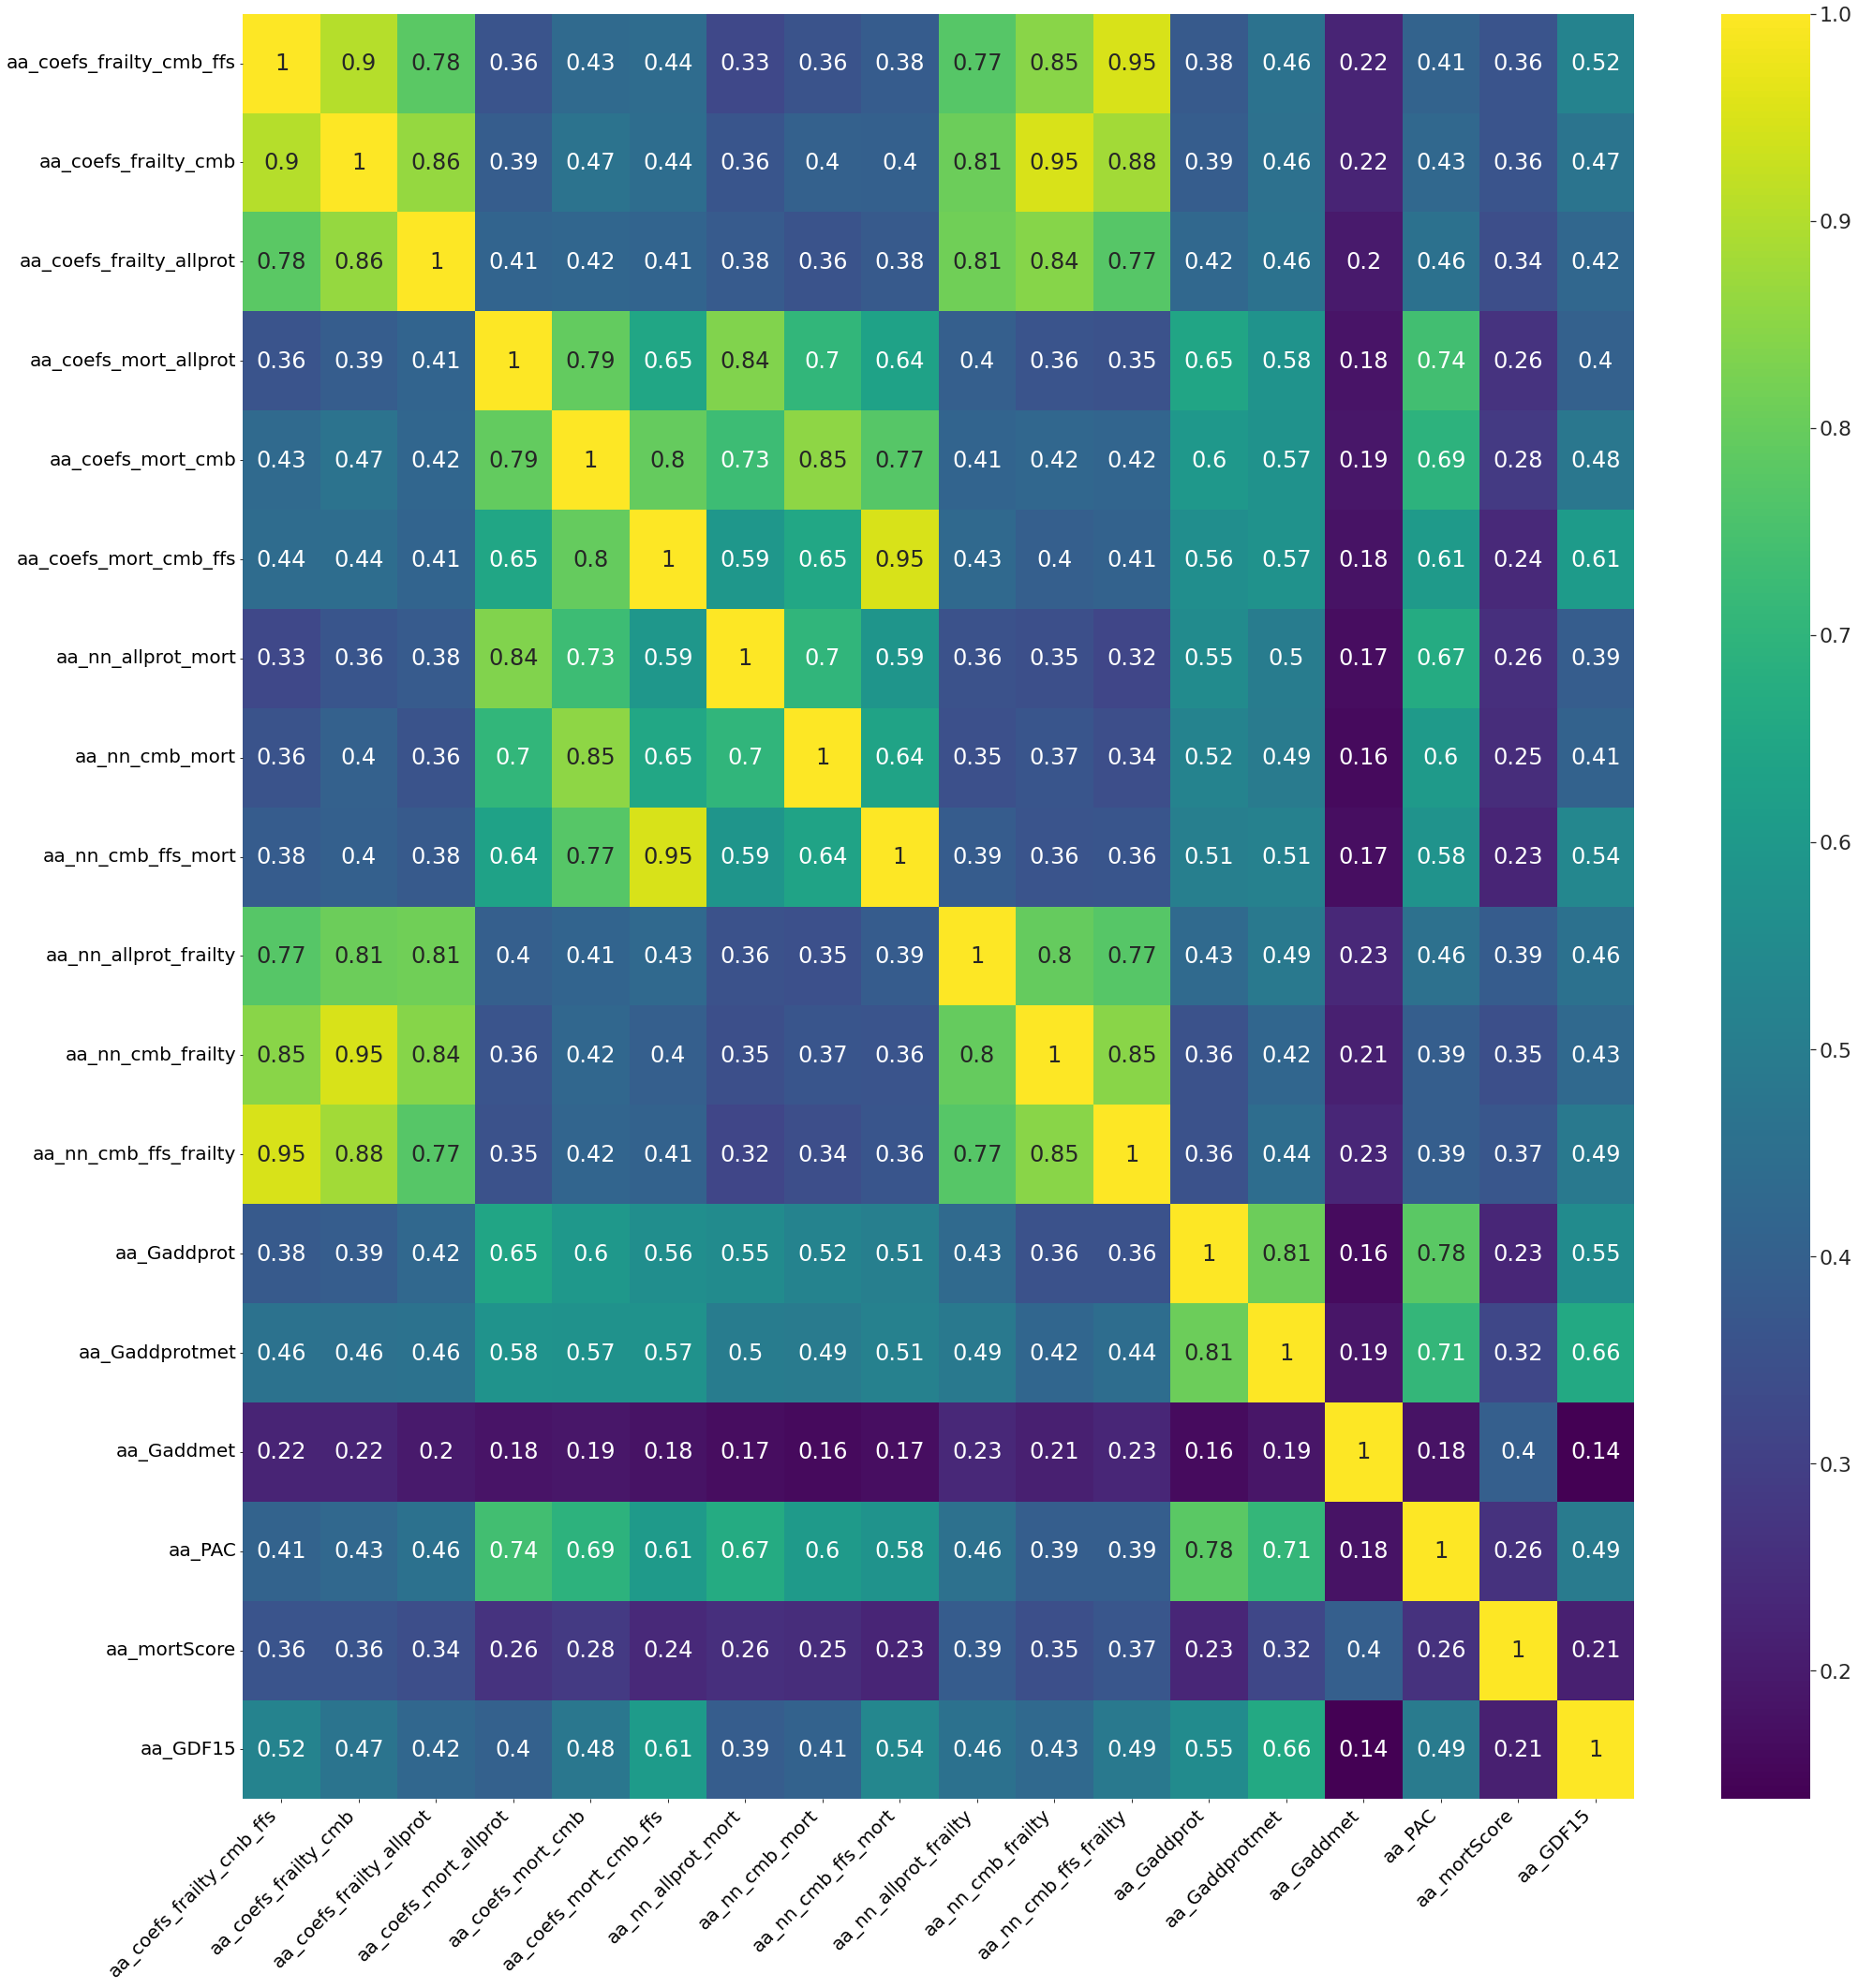

In [50]:
corraabiomarkers = cor_df.drop(columns=[col for col in cor_df.columns if not col.startswith('aa_')])
corraabiomarkers.columns = map(lambda x: x.replace('_proteins', ''), corraabiomarkers.columns)
print(corraabiomarkers.columns)

#corraabiomarkers_new = corraabiomarkers.reindex(columns = ['age', 'en_mort_all', 'en_mort_cmb', 'nnet_cmb', 'en_fi_all', 'en_fi_cmb','aa_en_mort_all', 'aa_en_mort_cmb', 'aa_nnet_cmb', 'aa_en_fi_all', 'aa_en_fi_cmb']).corr(method='spearman')
corraabiomarkers_cor = corraabiomarkers.corr(method='spearman')

# Create heatmap
# Generate a mask for the upper triangle
# mask = np.triu(np.ones_like(corraabiomarkers_new, dtype=bool))
fig, ax = plt.subplots(figsize=(30, 30))  # Adjust the size as per your preference
sns.set(font_scale=2)
corraabiomarkers_plot = sns.heatmap(corraabiomarkers_cor, cmap="viridis", annot=True, ax=ax)
plt.yticks(fontsize=20) 
plt.xticks(fontsize=20,rotation=45, ha='right') 
plt.tight_layout()

# Display the plot
plt.show()
#plt.savefig("correlations_set3.svg", backend='svg', transparent=True)

# Cox-PH regression on overall-mortality

In [51]:
additional_columns = [['sex'], ['sex', 'ses.0.0'], ['sex', 'ses.0.0','smokingyn.0.0', 'bmi.0.0'], ['sex', 'ses.0.0','smokingyn.0.0', 'bmi.0.0', 'lymf.0.0', 'mono.0.0']]
with_MetaboHealth = [['mortScore'] + sublist for sublist in additional_columns]
additional_columns.extend(with_MetaboHealth)

'mortScore' in additional_columns[0]
'mortScore' in additional_columns[7]

True

In [52]:
#Mortality analyses
# Initialize CoxPHFitter
cph_lifelines = CoxPHFitter()


#Event variables
events = [['died'], ['CVD_inc'], ['cancer_inc']]
censorage = [['censorage'], ['CVD_age'], ['cancer_age']]

# Prepare dataframe for coefficients
coefs = pd.DataFrame(columns=['outcome','variable', 'model','N', 'N_event', 'coef', 'se(coef)', 'exp(coef)', 'exp(coef) lower 95%', 'exp(coef) upper 95%', 'p', 'C',
                             'MH_coef', 'MH_HR', 'MH_LL', 'MH_UL', 'MH_p'])

# Additional columns to consider
additional_columns = [[],['sex'], ['sex', 'ses.0.0'], ['sex', 'ses.0.0','smokingyn.0.0', 'bmi.0.0'], ['sex', 'ses.0.0','smokingyn.0.0', 'bmi.0.0', 'lymf.0.0', 'mono.0.0']]

#Add MetaboHealth for comparison 
with_MetaboHealth = [['mortScore'] + sublist for sublist in additional_columns]
additional_columns.extend(with_MetaboHealth)

# Initialize scaler
scaler = StandardScaler()

#Make dataframe with all biomarkers available
compare_df2 = compare_df.dropna(
    subset=[
        column for column in compare_df.columns 
        if column.startswith('coefs_') 
        or column.startswith('nn_') 
        or column.startswith('Gadd') 
        or column in ['PAC', 'GDF15', 'mortScore']
    ],
    inplace=False
)


# Iterate through columns in compare_df2 to make sure size is same for all rounds, should discuss about that
for ageaccel in [True]:
    for column in compare_df2.columns:
        if column.startswith('coefs_') or column.startswith('nn_') or column.startswith('Gadd') or column == 'PAC' or column == 'GDF15' or column == 'mortScore':
            for o in range(len(events)):
                for i in range(len(additional_columns)):
                    if column == 'mortScore' and 'mortScore' in additional_columns[i]: #Adjusting MetaboHealth for MetaboHealth makes no sense
                        continue
                    out_vars = list(np.append(events[o], censorage[o])) 
                    model_data = compare_df2[[column] + additional_columns[i] + ['age'] + out_vars].copy()
                    # Drop rows with NaN values
                    model_data.dropna(how='any', inplace=True)
                
                    if i != 0:
                         # Extracting X (age) and y (the column to regress on)     
                        X = model_data['age'].values.reshape(-1, 1)     
                        y = model_data[column].values.reshape(-1, 1)
                        # Fitting linear regression model to determine Age Acceleration
                        aa_model = LinearRegression()
                        aa_model.fit(X, y)
            
                        # Calculating residuals
                        residuals = y - aa_model.predict(X)
                
                        # Creating new column for residuals
                        model_data[[column]] = residuals

                        if 'mortScore' in additional_columns[i]:
                            Xmh = model_data['age'].values.reshape(-1, 1)     
                            ymh = model_data['mortScore'].values.reshape(-1, 1)
                            # Fitting linear regression model to determine Age Acceleration
                            aa_mh_model = LinearRegression()
                            aa_mh_model.fit(Xmh, ymh)
                            residualsmh = ymh - aa_mh_model.predict(Xmh)
                
                            # Creating new column for residuals
                            model_data[['mortScore']] = residualsmh
                            model_data[['mortScore']] = scaler.fit_transform(model_data[['mortScore']])
                           
                    # Scale the column of interest
                    model_data[[column]] = scaler.fit_transform(model_data[[column]])
                    model_data.drop('age', axis =1, inplace=True)
        
                    
                    try:
                        if 'ses.0.0' in model_data.columns:
                            model_data = pd.get_dummies(model_data, columns=['ses.0.0'], drop_first = True)
                            
                        # Fit the Cox model
                        cph_lifelines.fit(model_data, censorage[o][0], events[o][0])
                        
                        # Get summary data
                        summary = cph_lifelines.summary
                        
                        # Extract coefficients for the column of interest
                        coef_values = summary.loc[[column], ['coef', 'se(coef)', 'exp(coef)', 'exp(coef) lower 95%', 'exp(coef) upper 95%', 'p']].copy()
                        
                        # Add additional information
                        coef_values['outcome'] = events[o][0]
                        coef_values['variable'] = f'aa_{column}' if ageaccel else column
                        coef_values['model'] = i
                        coef_values['N'] = len(cph_lifelines.durations)
                        coef_values['N_event'] = cph_lifelines.event_observed.sum()
                        coef_values['C'] = cph_lifelines.concordance_index_

                        if 'mortScore' in additional_columns[i]:
                            mh_values = summary.loc[['mortScore'], ['coef', 'se(coef)', 'exp(coef)', 'exp(coef) lower 95%', 'exp(coef) upper 95%', 'p']].copy()
                            #print(mh_values)
                            coef_values['MH_coef'] = mh_values['coef'].iloc[0]
                            coef_values['MH_HR'] = mh_values['exp(coef)'].iloc[0]
                            coef_values['MH_LL'] = mh_values['exp(coef) lower 95%'].iloc[0]
                            coef_values['MH_UL'] = mh_values['exp(coef) upper 95%'].iloc[0]
                            coef_values['MH_p'] = mh_values['p'].iloc[0]

                        else:
                            coef_values['MH_coef'] = np.nan
                            coef_values['MH_HR'] = np.nan
                            coef_values['MH_LL'] = np.nan
                            coef_values['MH_UL'] = np.nan
                            coef_values['MH_p'] = np.nan
                        
                        # Reorder columns
                        coef_values = coef_values[['outcome','variable', 'model','N', 'N_event', 'coef', 'se(coef)', 'exp(coef)', 'exp(coef) lower 95%', 'exp(coef) upper 95%', 'p', 'C',
                             'MH_coef', 'MH_HR', 'MH_LL', 'MH_UL', 'MH_p']]
                    
                        # Append to coefs dataframe
                        coefs = pd.concat([coefs, coef_values], ignore_index=True)
                        
                    except Exception as e:
                       print(f"Error fitting Cox model for {column}: {e}")

# Display or return the coefficients dataframe
coefs['HR_CI'] = coefs.apply(lambda row: f"{round(row['exp(coef)'],2)} ({round(row['exp(coef) lower 95%'],2)}; {round(row['exp(coef) upper 95%'],2)})", axis=1)
coefs['MH_CI'] = coefs.apply(lambda row: f"{round(row['MH_HR'],2)} ({round(row['MH_LL'],2)}; {round(row['MH_UL'],2)})", axis=1)

coefs['Concordance'] = round(coefs['C'],2)

print("Final Coefficients DataFrame:")
print(coefs)

coefs.to_csv('intermediate_results/olink_scaled_biomarkers_mortality.csv', index = False)

Final Coefficients DataFrame:
        outcome                  variable model     N N_event      coef  \
0          died  aa_coefs_frailty_cmb_ffs     0  2160     274  0.511048   
1          died  aa_coefs_frailty_cmb_ffs     1  2160     274  0.565390   
2          died  aa_coefs_frailty_cmb_ffs     2  2136     268  0.549890   
3          died  aa_coefs_frailty_cmb_ffs     3  2125     265  0.547013   
4          died  aa_coefs_frailty_cmb_ffs     4  2075     256  0.530670   
..          ...                       ...   ...   ...     ...       ...   
520  cancer_inc                  aa_GDF15     5  1955     341  0.150766   
521  cancer_inc                  aa_GDF15     6  1955     341  0.142268   
522  cancer_inc                  aa_GDF15     7  1935     334  0.165001   
523  cancer_inc                  aa_GDF15     8  1924     334  0.136515   
524  cancer_inc                  aa_GDF15     9  1878     328  0.150287   

     se(coef)  exp(coef)  exp(coef) lower 95%  exp(coef) upper 95%  \

In [53]:
c_set = coefs.loc[(coefs['model'] == 0) & (coefs['outcome']=='died') & coefs['variable'].str.contains('mort')]
c_set

,outcome,variable,model,N,N_event,coef,se(coef),exp(coef),exp(coef) lower 95%,exp(coef) upper 95%,p,C,MH_coef,MH_HR,MH_LL,MH_UL,MH_p,HR_CI,MH_CI,Concordance
90,died,aa_coefs_mort_allprot,0,2160,274,0.709047,0.044615,2.032054,1.861910,2.217746,7.145283e-57,0.745297,NaN,NaN,NaN,NaN,NaN,2.03 (1.86; 2.22),nan (nan; nan),0.75
120,died,aa_coefs_mort_cmb,0,2160,274,0.578895,0.039196,1.784066,1.652143,1.926523,2.307459e-49,0.712779,NaN,NaN,NaN,NaN,NaN,1.78 (1.65; 1.93),nan (nan; nan),0.71
150,died,aa_coefs_mort_cmb_ffs,0,2160,274,0.603016,0.047026,1.827623,1.666703,2.004079,1.216767e-37,0.697453,NaN,NaN,NaN,NaN,NaN,1.83 (1.67; 2.0),nan (nan; nan),0.70
180,died,aa_nn_allprot_mort,0,2160,274,0.642197,0.043411,1.900653,1.745628,2.069445,1.611667e-49,0.726392,NaN,NaN,NaN,NaN,NaN,1.9 (1.75; 2.07),nan (nan; nan),0.73
210,died,aa_nn_cmb_mort,0,2160,274,0.686690,0.047568,1.987128,1.810238,2.181303,3.074916e-47,0.719206,NaN,NaN,NaN,NaN,NaN,1.99 (1.81; 2.18),nan (nan; nan),0.72
240,died,aa_nn_cmb_ffs_mort,0,2160,274,0.534736,0.040410,1.706998,1.577016,1.847693,5.667800e-40,0.701384,NaN,NaN,NaN,NaN,NaN,1.71 (1.58; 1.85),nan (nan; nan),0.70
480,died,aa_mortScore,0,2160,274,0.345005,0.054322,1.411997,1.269389,1.570627,2.138168e-10,0.609288,NaN,NaN,NaN,NaN,NaN,1.41 (1.27; 1.57),nan (nan; nan),0.61


In [54]:
full_model_alone = coefs.loc[coefs['model']==3]
cmb_ffs2 = full_model_alone[
    (full_model_alone["variable"] == 'aa_coefs_frailty_cmb') |
  #  (full_model_alone["variable"] == 'aa_mortScore') |
    (full_model_alone["variable"] == 'aa_coefs_mort_cmb')
]
cmb_ffs2

,outcome,variable,model,N,N_event,coef,se(coef),exp(coef),exp(coef) lower 95%,exp(coef) upper 95%,p,C,MH_coef,MH_HR,MH_LL,MH_UL,MH_p,HR_CI,MH_CI,Concordance
33,died,aa_coefs_frailty_cmb,3,2125,265,0.577525,0.056327,1.781623,1.595403,1.989579,1.145661e-24,0.716711,NaN,NaN,NaN,NaN,NaN,1.78 (1.6; 1.99),nan (nan; nan),0.72
43,CVD_inc,aa_coefs_frailty_cmb,3,2030,190,0.342986,0.074919,1.409149,1.216708,1.632029,4.691715e-06,0.685808,NaN,NaN,NaN,NaN,NaN,1.41 (1.22; 1.63),nan (nan; nan),0.69
53,cancer_inc,aa_coefs_frailty_cmb,3,1924,334,0.129256,0.059474,1.137981,1.012769,1.278673,2.975717e-02,0.575186,NaN,NaN,NaN,NaN,NaN,1.14 (1.01; 1.28),nan (nan; nan),0.58
123,died,aa_coefs_mort_cmb,3,2125,265,0.515269,0.050217,1.674088,1.517168,1.847239,1.057785e-24,0.716071,NaN,NaN,NaN,NaN,NaN,1.67 (1.52; 1.85),nan (nan; nan),0.72
133,CVD_inc,aa_coefs_mort_cmb,3,2030,190,0.197384,0.072924,1.218211,1.055965,1.405386,6.795491e-03,0.666074,NaN,NaN,NaN,NaN,NaN,1.22 (1.06; 1.41),nan (nan; nan),0.67
143,cancer_inc,aa_coefs_mort_cmb,3,1924,334,0.114452,0.056283,1.121258,1.004148,1.252027,4.200100e-02,0.584057,NaN,NaN,NaN,NaN,NaN,1.12 (1.0; 1.25),nan (nan; nan),0.58


In [55]:
full_model = coefs.loc[coefs['model']==7]
# Create HR_CI
full_model['HR_CI'] = full_model.apply(lambda row: f"{round(row['exp(coef)'],2)} ({round(row['exp(coef) lower 95%'],2)}; {round(row['exp(coef) upper 95%'],2)})", axis=1)
full_model['MH_CI'] = full_model.apply(lambda row: f"{round(row['MH_HR'],2)} ({round(row['MH_LL'],2)}; {round(row['MH_UL'],2)})", axis=1)

full_model['Concordance'] = round(full_model['C'],2)
full_model['HR_CI'].head()
full_model[['variable','HR_CI','Concordance']]
full_model

,outcome,variable,model,N,N_event,coef,se(coef),exp(coef),exp(coef) lower 95%,exp(coef) upper 95%,p,C,MH_coef,MH_HR,MH_LL,MH_UL,MH_p,HR_CI,MH_CI,Concordance
7,died,aa_coefs_frailty_cmb_ffs,7,2136,268,0.473834,0.055895,1.606141,1.439481,1.792096,2.305622e-17,0.708985,0.190767,1.210177,1.077482,1.359214,1.284729e-03,1.61 (1.44; 1.79),1.21 (1.08; 1.36),0.71
17,CVD_inc,aa_coefs_frailty_cmb_ffs,7,2041,191,0.350157,0.071515,1.419291,1.233666,1.632846,9.767618e-07,0.679995,0.104532,1.110191,0.956505,1.288572,1.691273e-01,1.42 (1.23; 1.63),1.11 (0.96; 1.29),0.68
27,cancer_inc,aa_coefs_frailty_cmb_ffs,7,1935,334,0.110310,0.057613,1.116624,0.997395,1.250107,5.553239e-02,0.560440,0.012033,1.012106,0.898952,1.139503,8.423216e-01,1.12 (1.0; 1.25),1.01 (0.9; 1.14),0.56
37,died,aa_coefs_frailty_cmb,7,2136,268,0.521615,0.057617,1.684746,1.504841,1.886158,1.389112e-19,0.718240,0.149136,1.160831,1.031294,1.306639,1.349644e-02,1.68 (1.5; 1.89),1.16 (1.03; 1.31),0.72
47,CVD_inc,aa_coefs_frailty_cmb,7,2041,191,0.350465,0.072348,1.419728,1.232034,1.636016,1.271376e-06,0.682210,0.092688,1.097120,0.944116,1.274918,2.264560e-01,1.42 (1.23; 1.64),1.1 (0.94; 1.27),0.68
57,cancer_inc,aa_coefs_frailty_cmb,7,1935,334,0.150045,0.057471,1.161887,1.038113,1.300419,9.032857e-03,0.569232,-0.007150,0.992876,0.881245,1.118647,9.064726e-01,1.16 (1.04; 1.3),0.99 (0.88; 1.12),0.57
67,died,aa_coefs_frailty_allprot,7,2136,268,0.483452,0.057303,1.621663,1.449388,1.814415,3.260477e-17,0.713217,0.161808,1.175635,1.046636,1.320534,6.360331e-03,1.62 (1.45; 1.81),1.18 (1.05; 1.32),0.71
77,CVD_inc,aa_coefs_frailty_allprot,7,2041,191,0.374079,0.069218,1.453652,1.269235,1.664863,6.503313e-08,0.685810,0.082477,1.085974,0.936814,1.258884,2.739075e-01,1.45 (1.27; 1.66),1.09 (0.94; 1.26),0.69
87,cancer_inc,aa_coefs_frailty_allprot,7,1935,334,0.144665,0.056043,1.155652,1.035435,1.289827,9.843004e-03,0.566944,-0.002943,0.997061,0.886151,1.121852,9.609812e-01,1.16 (1.04; 1.29),1.0 (0.89; 1.12),0.57
97,died,aa_coefs_mort_allprot,7,2136,268,0.602639,0.054969,1.826934,1.640337,2.034756,5.738591e-28,0.731784,0.095711,1.100441,0.976360,1.240290,1.168756e-01,1.83 (1.64; 2.03),1.1 (0.98; 1.24),0.73


In [56]:
cmb_ffs = full_model[
    (full_model["variable"] == 'aa_coefs_frailty_cmb_ffs') |
    (full_model["variable"] == 'aa_coefs_mort_cmb_ffs') |
    (full_model["variable"] == 'aa_coefs_frailty_cmb')|
    (full_model["variable"] == 'aa_coefs_mort_cmb')
]
cmb_ffs

,outcome,variable,model,N,N_event,coef,se(coef),exp(coef),exp(coef) lower 95%,exp(coef) upper 95%,p,C,MH_coef,MH_HR,MH_LL,MH_UL,MH_p,HR_CI,MH_CI,Concordance
7,died,aa_coefs_frailty_cmb_ffs,7,2136,268,0.473834,0.055895,1.606141,1.439481,1.792096,2.305622e-17,0.708985,0.190767,1.210177,1.077482,1.359214,0.001285,1.61 (1.44; 1.79),1.21 (1.08; 1.36),0.71
17,CVD_inc,aa_coefs_frailty_cmb_ffs,7,2041,191,0.350157,0.071515,1.419291,1.233666,1.632846,9.767618e-07,0.679995,0.104532,1.110191,0.956505,1.288572,0.169127,1.42 (1.23; 1.63),1.11 (0.96; 1.29),0.68
27,cancer_inc,aa_coefs_frailty_cmb_ffs,7,1935,334,0.110310,0.057613,1.116624,0.997395,1.250107,5.553239e-02,0.560440,0.012033,1.012106,0.898952,1.139503,0.842322,1.12 (1.0; 1.25),1.01 (0.9; 1.14),0.56
37,died,aa_coefs_frailty_cmb,7,2136,268,0.521615,0.057617,1.684746,1.504841,1.886158,1.389112e-19,0.718240,0.149136,1.160831,1.031294,1.306639,0.013496,1.68 (1.5; 1.89),1.16 (1.03; 1.31),0.72
47,CVD_inc,aa_coefs_frailty_cmb,7,2041,191,0.350465,0.072348,1.419728,1.232034,1.636016,1.271376e-06,0.682210,0.092688,1.097120,0.944116,1.274918,0.226456,1.42 (1.23; 1.64),1.1 (0.94; 1.27),0.68
57,cancer_inc,aa_coefs_frailty_cmb,7,1935,334,0.150045,0.057471,1.161887,1.038113,1.300419,9.032857e-03,0.569232,-0.007150,0.992876,0.881245,1.118647,0.906473,1.16 (1.04; 1.3),0.99 (0.88; 1.12),0.57
127,died,aa_coefs_mort_cmb,7,2136,268,0.510369,0.051652,1.665907,1.505514,1.843387,5.033215e-23,0.716586,0.110457,1.116789,0.993489,1.255391,0.064239,1.67 (1.51; 1.84),1.12 (0.99; 1.26),0.72
137,CVD_inc,aa_coefs_mort_cmb,7,2041,191,0.197087,0.075451,1.217850,1.050435,1.411946,8.998707e-03,0.654423,0.154877,1.167514,1.003161,1.358794,0.045421,1.22 (1.05; 1.41),1.17 (1.0; 1.36),0.65
147,cancer_inc,aa_coefs_mort_cmb,7,1935,334,0.159645,0.058701,1.173095,1.045602,1.316133,6.535676e-03,0.576664,-0.014867,0.985242,0.873094,1.111796,0.809451,1.17 (1.05; 1.32),0.99 (0.87; 1.11),0.58
157,died,aa_coefs_mort_cmb_ffs,7,2136,268,0.536790,0.060072,1.710508,1.520517,1.924238,4.044815e-19,0.712372,0.131767,1.140843,1.013673,1.283966,0.028876,1.71 (1.52; 1.92),1.14 (1.01; 1.28),0.71


In [57]:
inc_model0 = coefs.loc[coefs['model']==0]
# Create HR_CI
inc_model0['HR_CI'] = inc_model0.apply(lambda row: f"{round(row['exp(coef)'],2)} ({round(row['exp(coef) lower 95%'],2)}; {round(row['exp(coef) upper 95%'],2)})", axis=1)
inc_model0['Concordance'] = round(inc_model0['C'],2)
inc_model0['HR_CI'].head()
inc_model0[['variable','HR_CI','Concordance']]

,variable,HR_CI,Concordance
0,aa_coefs_frailty_cmb_ffs,1.67 (1.5; 1.86),0.62
10,aa_coefs_frailty_cmb_ffs,1.29 (1.12; 1.48),0.57
20,aa_coefs_frailty_cmb_ffs,0.99 (0.89; 1.1),0.53
30,aa_coefs_frailty_cmb,1.72 (1.55; 1.91),0.64
40,aa_coefs_frailty_cmb,1.28 (1.12; 1.47),0.58
50,aa_coefs_frailty_cmb,1.02 (0.92; 1.14),0.48
60,aa_coefs_frailty_allprot,1.65 (1.49; 1.83),0.64
70,aa_coefs_frailty_allprot,1.33 (1.18; 1.51),0.59
80,aa_coefs_frailty_allprot,1.04 (0.94; 1.15),0.49
90,aa_coefs_mort_allprot,2.03 (1.86; 2.22),0.75


In [58]:
coefs_plot = coefs
coefs_plot.rename(columns={'exp(coef)':'Coef', 'exp(coef) lower 95%':'LL', 'exp(coef) upper 95%':'UL'}, inplace = True)
coefs_plot

,outcome,variable,model,N,N_event,coef,se(coef),Coef,LL,UL,p,C,MH_coef,MH_HR,MH_LL,MH_UL,MH_p,HR_CI,MH_CI,Concordance
0,died,aa_coefs_frailty_cmb_ffs,0,2160,274,0.511048,0.054718,1.667037,1.497507,1.855759,9.668911e-21,0.624358,NaN,NaN,NaN,NaN,NaN,1.67 (1.5; 1.86),nan (nan; nan),0.62
1,died,aa_coefs_frailty_cmb_ffs,1,2160,274,0.565390,0.049095,1.760134,1.598659,1.937918,1.092912e-30,0.700968,NaN,NaN,NaN,NaN,NaN,1.76 (1.6; 1.94),nan (nan; nan),0.70
2,died,aa_coefs_frailty_cmb_ffs,2,2136,268,0.549890,0.049925,1.733062,1.571513,1.911219,3.260116e-28,0.701778,NaN,NaN,NaN,NaN,NaN,1.73 (1.57; 1.91),nan (nan; nan),0.70
3,died,aa_coefs_frailty_cmb_ffs,3,2125,265,0.547013,0.057892,1.728083,1.542719,1.935719,3.425121e-21,0.707856,NaN,NaN,NaN,NaN,NaN,1.73 (1.54; 1.94),nan (nan; nan),0.71
4,died,aa_coefs_frailty_cmb_ffs,4,2075,256,0.530670,0.061314,1.700072,1.507567,1.917157,4.930193e-18,0.706973,NaN,NaN,NaN,NaN,NaN,1.7 (1.51; 1.92),nan (nan; nan),0.71
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
520,cancer_inc,aa_GDF15,5,1955,341,0.150766,0.051746,1.162724,1.050582,1.286836,3.573499e-03,0.539927,-0.014121,0.985978,0.884025,1.099688,0.799823,1.16 (1.05; 1.29),0.99 (0.88; 1.1),0.54
521,cancer_inc,aa_GDF15,6,1955,341,0.142268,0.053563,1.152885,1.037989,1.280499,7.906038e-03,0.539370,-0.004104,0.995904,0.889316,1.115268,0.943351,1.15 (1.04; 1.28),1.0 (0.89; 1.12),0.54
522,cancer_inc,aa_GDF15,7,1935,334,0.165001,0.053772,1.179394,1.061421,1.310480,2.151338e-03,0.571140,0.003143,1.003148,0.894481,1.125017,0.957148,1.18 (1.06; 1.31),1.0 (0.89; 1.13),0.57
523,cancer_inc,aa_GDF15,8,1924,334,0.136515,0.056656,1.146272,1.025799,1.280895,1.597234e-02,0.577070,0.006678,1.006701,0.896837,1.130023,0.909819,1.15 (1.03; 1.28),1.01 (0.9; 1.13),0.58


In [59]:
intersection_set = set(['aap.0.0']).intersection(set(['age', 'sex', 'ses.0.0', 'smokingyn.0.0', 'bmi.0.0', 'lymf.0.0', 'mono.0.0']))
len(intersection_set)

0

In [60]:
# logit = Logit(compare_frailty['hbp.0.0'],add_constant(compare_frailty[['age', 'sex']])).fit()
# summary = logit.summary()
# summary.tables

In [61]:
# Frailty
# Add frailty to compare_df and create compare_frailty
compare_frailty = compare_df2.merge(frailty_set3, left_index=True, right_index=True)

true_outcomes = [['FI_0'], ['CVD_prev'], ['hbp.0.0'], ['cancer_prev'], ['max_handgrip'], ['poor_health']] 
riskfact = [['smokingyn.0.0'], ['bmi.0.0']]
outcomes = true_outcomes + riskfact
print(outcomes)

# Additional columns to consider
frailty_additional_columns = [['age'],
                              ['age'],
                              ['age', 'sex'], 
                              ['age', 'sex', 'ses.0.0'], 
                              ['age', 'sex', 'ses.0.0', 'smokingyn.0.0', 'bmi.0.0'], 
                              ['age', 'sex', 'ses.0.0', 'smokingyn.0.0', 'bmi.0.0', 'lymf.0.0', 'mono.0.0']]

#Add MetaboHealth for comparison 
with_MetaboHealth_frailty = [['mortScore'] + sublist for sublist in frailty_additional_columns]
frailty_additional_columns.extend(with_MetaboHealth_frailty)

# Initialize scaler
scaler = StandardScaler()
results = []

# Iterate through columns in compare_frailty
for ageaccel in [True]:
    for out in outcomes:
        for column in compare_frailty.columns:
             if column.startswith('coefs_') or column.startswith('nn_') or column.startswith('Gadd') or column == 'PAC' or column == 'GDF15' or column == 'mortScore':
                 for i in range(len(frailty_additional_columns)): 
                    if column == 'mortScore' and 'mortScore' in frailty_additional_columns[i]: #Adjusting MetaboHealth for MetaboHealth makes no sense
                        continue
                    if len(set(out).intersection(set(frailty_additional_columns[i]))) == 0:
                        frailty_add = list(np.append(out, frailty_additional_columns[i]))
                        model_data = compare_frailty[[column] + frailty_add].copy()
                    else:
                        model_data = compare_frailty[[column] + frailty_additional_columns[i]].copy()
                        model_data = model_data.reindex(columns=(out + list([a for a in model_data.columns if a != out[0]]) ))
                       
                    # Drop rows with NaN values
                    model_data.dropna(how='any', inplace=True)
                    if i != 0:
                        # Extracting X (age) and y (the column to regress on)
                        Xres = model_data['age'].values.reshape(-1, 1)
                        yres = model_data[column].values.reshape(-1, 1)
                        # Fitting linear regression model to determine Age Acceleration
                        aa_model = LinearRegression()
                        aa_model.fit(Xres, yres)

                        # Calculating residuals
                        residuals = yres - aa_model.predict(Xres)
                    
                        # Creating new column for residuals
                        model_data[[column]] = residuals
                    
                        if 'mortScore' in frailty_additional_columns[i]:  # Fix indentation here
                            Xmh = model_data['age'].values.reshape(-1, 1)
                            ymh = model_data['mortScore'].values.reshape(-1, 1)
                            # Fitting linear regression model to determine Age Acceleration
                            aa_mh_model = LinearRegression()
                            aa_mh_model.fit(Xmh, ymh)
                            residualsmh = ymh - aa_mh_model.predict(Xmh)
                    
                            # Creating new column for residuals
                            model_data[['mortScore']] = residualsmh
                            model_data[['mortScore']] = scaler.fit_transform(model_data[['mortScore']])
                    
                    # Scale the column of interest
                    model_data[[column]] = scaler.fit_transform(model_data[[column]])

                    # Drop age column if present (for age acceleration)
                    model_data.drop(columns=['age'], inplace=True)

                    # Make frailty outcome
                    if out[0] in [x[0] for x in true_outcomes]:  # Fixed check for true_outcomes
                        X = model_data.drop(columns=out[0])
                        y = model_data[out]
                    else:
                        X = model_data.drop(columns=column)
                        y = model_data[column]

                    # Check whether a factor or not
                    if len(np.unique(y.values)) > 2:
                        # Linear regression
                        an_type = 'linear'
                        reg = OLS(y, add_constant(X, prepend=True)).fit()
                        # R-squared
                        r_squared = reg.rsquared
                        coef = reg.params.iloc[1]
                        std_err = reg.bse.iloc[1]
                        conf_int_025, conf_int_975 = reg.conf_int().iloc[1]
                        Ncase = None
                        if 'mortScore' in frailty_additional_columns[i]:
                            MH_coef = reg.params.iloc[2]
                            MH_LL, MH_UL = reg.conf_int().iloc[2]
                            MH_p = reg.pvalues.iloc[2]
                        else:
                            MH_coef = MH_LL = MH_UL = MH_p = np.nan

                         
                    elif len(np.unique(y.values)) == 2:
                        # Logistic regression
                        an_type = 'logistic'
                        reg = Logit(y, add_constant(X, prepend=True)).fit()
                        # Exponentiate coefficients for odds ratios
                        coef = np.exp(reg.params.iloc[1])
                        std_err = np.exp(reg.bse.iloc[1])
                        conf_int_025, conf_int_975 = np.exp(reg.conf_int().iloc[1])
                        # Ncase = X[out].sum()
                        Ncase = y[out].sum()

                        # R-squared only as pseudo R-squared
                        r_squared = reg.prsquared
                        if 'mortScore' in frailty_additional_columns[i]:
                            MH_coef = np.exp(reg.params.iloc[2])
                            MH_LL, MH_UL = np.exp(reg.conf_int().iloc[2])
                            MH_p = reg.pvalues.iloc[2]
                        else:
                            MH_coef = MH_LL = MH_UL = MH_p = np.nan
                   
                    # Store results for this iteration
                    results.append({
                        'type': an_type,
                        'outcome': out[0],
                        'variable': f'aa_{column}' if ageaccel else column,
                        'model': i,
                        'N': len(y),
                        'Ncase': Ncase,
                        'Coef': coef,
                        'Std Err': std_err,
                        't-value': reg.tvalues.iloc[1],
                        'P': reg.pvalues.iloc[1],
                        'LL': conf_int_025,
                        'UL': conf_int_975,
                        'R-squared': r_squared,
                        'MH_coef' : MH_coef,
                        'MH_LL' : MH_LL,
                        'MH_UL' : MH_UL,
                        'MH_p' : MH_p
                    })

# Convert results list to pandas DataFrame
results_df = pd.DataFrame(results)
results_df['Beta_CI'] = results_df.apply(lambda row: f"{round(row['Coef'],2)} ({round(row['LL'],2)}; {round(row['UL'],2)})", axis=1)
results_df['R2'] = round(results_df['R-squared'], 2)

print(results_df)
results_df.to_csv('intermediate_results/olink_scaled_biomarkers_frailty.csv', index=False)


[['FI_0'], ['CVD_prev'], ['hbp.0.0'], ['cancer_prev'], ['max_handgrip'], ['poor_health'], ['smokingyn.0.0'], ['bmi.0.0']]
Optimization terminated successfully.
         Current function value: 0.162192
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.168710
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.161085
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.158830
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.157770
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.155943
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.168013
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.168013
         Iterations 8
Optimization terminated successfully.
         Current functio

In [62]:
r2_set3 = results_df.loc[(results_df['model']==0) & (results_df['outcome'] == 'FI_0') & (results_df['variable'].str.contains('frailty'))]
r2_set3

,type,outcome,variable,model,N,Ncase,Coef,Std Err,t-value,P,LL,UL,R-squared,MH_coef,MH_LL,MH_UL,MH_p,Beta_CI,R2
0,linear,FI_0,aa_coefs_frailty_cmb_ffs,0,2160,None,0.032548,0.001505,21.632412,4.344094e-94,0.029597,0.035498,0.178206,NaN,NaN,NaN,NaN,0.03 (0.03; 0.04),0.18
12,linear,FI_0,aa_coefs_frailty_cmb,0,2160,None,0.035719,0.001471,24.284033,2.288101e-115,0.032834,0.038603,0.214620,NaN,NaN,NaN,NaN,0.04 (0.03; 0.04),0.21
24,linear,FI_0,aa_coefs_frailty_allprot,0,2160,None,0.040532,0.001412,28.707881,8.689165e-154,0.037763,0.043301,0.276359,NaN,NaN,NaN,NaN,0.04 (0.04; 0.04),0.28
108,linear,FI_0,aa_nn_allprot_frailty,0,2160,None,0.037596,0.001449,25.945534,2.071403e-129,0.034754,0.040437,0.237771,NaN,NaN,NaN,NaN,0.04 (0.03; 0.04),0.24
120,linear,FI_0,aa_nn_cmb_frailty,0,2160,None,0.037301,0.001453,25.680004,3.927306e-127,0.034453,0.040150,0.234063,NaN,NaN,NaN,NaN,0.04 (0.03; 0.04),0.23
132,linear,FI_0,aa_nn_cmb_ffs_frailty,0,2160,None,0.035229,0.001476,23.862980,6.848313e-112,0.032334,0.038125,0.208782,NaN,NaN,NaN,NaN,0.04 (0.03; 0.04),0.21


In [63]:
results_df['variable'].unique()

array(['aa_coefs_frailty_cmb_ffs', 'aa_coefs_frailty_cmb',
       'aa_coefs_frailty_allprot', 'aa_coefs_mort_allprot',
       'aa_coefs_mort_cmb', 'aa_coefs_mort_cmb_ffs', 'aa_nn_allprot_mort',
       'aa_nn_cmb_mort', 'aa_nn_cmb_ffs_mort', 'aa_nn_allprot_frailty',
       'aa_nn_cmb_frailty', 'aa_nn_cmb_ffs_frailty', 'aa_Gaddprot',
       'aa_Gaddprotmet', 'aa_Gaddmet', 'aa_PAC', 'aa_mortScore',
       'aa_GDF15'], dtype=object)

In [64]:
bla = coefs_plot[coefs_plot['model'] == 3]


In [65]:
own_models = np.array(['aa_coefs_frailty_cmb_met_ffs', 'aa_coefs_frailty_cmb_met',
       'aa_coefs_frailty_cmb', 'aa_coefs_frailty_allprot',
       'aa_coefs_frailty_cmb_ffs', 'aa_coefs_frailty_allprot_ffs',
       'aa_coefs_mort_cmb_met_ffs', 'aa_coefs_mort_cmb_ffs',
       'aa_coefs_mort_allprot_ffs', 'aa_coefs_mort_cmb',
       'aa_coefs_mort_cmb_met', 'aa_coefs_mort_allprot',
       'aa_nn_allprot_mort', 'aa_nn_cmb_mort', 'aa_nn_cmb_met_mort',
       'aa_nn_allprot_frailty', 'aa_nn_cmb_frailty',
       'aa_nn_cmb_met_frailty', 'aa_nn_cmb_ffs_frailty',
       'aa_nn_cmb_met_ffs_frailty', 'aa_nn_allprot_ffs_frailty'])

selected_models =  np.array([
       'aa_coefs_frailty_cmb', 'aa_coefs_frailty_allprot', 'aa_coefs_frailty_allprot_ffs',
       'aa_coefs_mort_cmb', 'aa_coefs_mort_allprot',
    'aa_nn_allprot_mort', 'aa_nn_cmb_mort', 
    'aa_nn_allprot_frailty', 'aa_nn_cmb_frailty', 'aa_nn_allprot_ffs_frailty'])

external_models = np.array(['aa_Gaddprot', 'aa_Gaddprotmet', 'aa_Gaddmet', 'aa_PAC',
       'aa_mortScore', 'aa_GDF15'])


selected_mapping = {
    'aa_coefs_frailty_cmb' : "EN_FT_CMB",
    'aa_coefs_frailty_allprot' : "EN_FT_ALLPROT",
    'aa_coefs_frailty_cmb_ffs' : "EN_FT_CMB_FFS",
    'aa_coefs_frailty_allprot_ffs' : "EN_FT_FFS",
    'aa_coefs_mort_cmb' : "EN_MORT_CMB", 
    'aa_coefs_mort_allprot' : "EN_MORT_ALLPROT",
    'aa_nn_allprot_mort' : "NN_MORT_ALLPROT",
    'aa_nn_cmb_mort' : "NN_MORT_CMB",
    'aa_nn_allprot_frailty' :"NN_FT_ALLPROT",
    'aa_nn_cmb_frailty' : "NN_FT_CMB",
    'aa_nn_cmb_ffs_frailty' : "NN_FT_CMB_FFS",
    'aa_nn_allprot_ffs_frailty' : "NN_FT_FFS",
    'aa_Gaddprot' : "Gadd_Prot",
    'aa_Gaddprotmet' : "Gadd_Prot_met",
    'aa_Gaddmet' : "Gadd_met",
    'aa_PAC' : "PAC",
    'aa_mortScore' : 'metaboHealth',
    'aa_GDF15' : "GDF15_only"}

inc_outcomes = ['died', 'CVD_inc', 'cancer_inc']

def make_forestplots(model_id, outcome_name, name_mapping = None, compare_external = False, negative = False):

    if outcome_name in inc_outcomes:
        sel_df = coefs_plot
    else:
        sel_df = results_df
    # print(f'outcome_name : {outcome_name}')
    model_df = sel_df[sel_df['model'] == model_id]
    model_outcome_df = model_df[model_df['outcome'] == outcome_name]
    # final_df = model_outcome_df[model_outcome_df['variable'].isin(markers_of_interest)]
    # own_models = model_outcome_df[model_outcome_df['variable'].isin(own_models)]
    



    own_models_df = model_outcome_df[model_outcome_df['variable'].isin(selected_models)]

    if compare_external == True:
        
        sort_idx = np.argsort(own_models_df['Coef'].values)
        if negative:
            top3_idx = sort_idx[:3]
        else:
            top3_idx = sort_idx[-3:]
        top3_names = own_models_df.iloc[top3_idx]['variable'].values
        print(f'Top 3: {top3_names}')
        name_list = np.concatenate((top3_names, external_models))
        final_df = model_outcome_df[model_outcome_df['variable'].isin(name_list)]
    else:
        final_df = own_models_df


    if name_mapping is not None:
        final_df['plot_names'] = [name_mapping[val] for val in final_df['variable'].values]
    else:
        final_df['plot_names'] = final_df['variable']
    # print(final_df.head()) 
    fp.forestplot(final_df,  # the dataframe with results data
              estimate="Coef",  # col containing estimated effect size 
              ll="LL",
              hl="UL",  # columns containing conf. int. margin of error
              varlabel="plot_names",  # column containing variable label
              color_alt_rows=True,  # Gray alternate rows
              mcolor=["#000000"],
              sort=True,
                **{
                    "linecolor" : ".0",
                    "lw" : 1.5
                }
                    )  # sort in ascending order (sorts within group if group is specified)              
                 
    plt.title(f"association with {outcome_name}")

Top 3: ['aa_coefs_mort_allprot' 'aa_nn_allprot_frailty' 'aa_nn_allprot_mort']


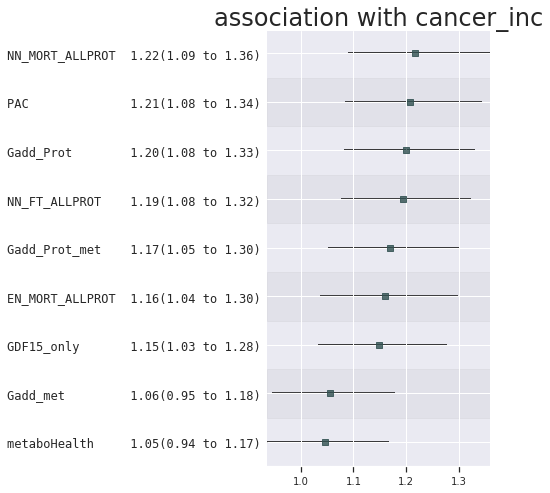

In [66]:
true_outcomes = [['FI_0'], ['CVD_prev'], ['hbp.0.0'], ['cancer_prev'], ['max_handgrip'], ['self_perceived_health']] 
riskfact = [['smokingyn.0.0'], ['bmi.0.0']]
inc_outcomes = ['died', 'CVD_inc', 'cancer_inc']

# true_outcomes[5][0]
make_forestplots(3,inc_outcomes[2],name_mapping = selected_mapping, compare_external =True, negative = False)

In [67]:
true_outcomes[1][0]

'CVD_prev'

In [68]:
compare_frailty['FI_0'].describe()

count    2160.000000
mean        0.129789
std         0.077119
min         0.000000
25%         0.076531
50%         0.116837
75%         0.168367
max         0.475510
Name: FI_0, dtype: float64

In [69]:
model_sel = model0.loc[model0['variable'].isin( ['aa_coefs_frailty_cmb', 'aa_coefs_frailty_allprot','aa_coefs_frailty_cmb_ffs', 'aa_coefs_frailty_allprot_ffs',
                                              'aa_coefs_mort_cmb', 'aa_coefs_mort_allprot',
                                              'aa_nn_allprot_mort', 'aa_nn_cmb_mort', 'aa_nn_allprot_frailty', 'aa_nn_cmb_frailty',
                                              'aa_nn_cmb_ffs_frailty', 'aa_nn_allprot_ffs_frailty'])]


mapping = {
    'aa_coefs_frailty_cmb' : "EN_FT_CMB",
    'aa_coefs_frailty_allprot' : "EN_FT_ALLPROT",
    'aa_coefs_frailty_cmb_ffs' : "EN_FT_CMB_FFS",
    'aa_coefs_frailty_allprot_ffs' : "EN_FT_ALLPROT_FFS",
    'aa_coefs_mort_cmb' : "EN_MORT_CMB", 
    'aa_coefs_mort_allprot' : "EN_MORT_ALLPROT",
    'aa_nn_allprot_mort' : "NN_MORT_ALLPROT",
    'aa_nn_cmb_mort' : "NN_MORT_CMB",
    'aa_nn_allprot_frailty' :"NN_FT_ALLPROT",
    'aa_nn_cmb_frailty' : "NN_FT_CMB",
    'aa_nn_cmb_ffs_frailty' : "NN_FT_CMB_FFS",
    'aa_nn_allprot_ffs_frailty' : "NN_FT_ALLPROT_FFS"}

model_sel['plot_names'] =[mapping[val] for val in model_sel['variable'].values]



NameError: name 'model0' is not defined

In [ ]:
model_sel.head()

In [ ]:
import forestplot as fp

fp.forestplot(model_sel,  # the dataframe with results data
              estimate="Coef",  # col containing estimated effect size 
              ll="LL",
              hl="UL",  # columns containing conf. int. margin of error
              varlabel="plot_names",  # column containing variable label
              color_alt_rows=True,  # Gray alternate rows
              mcolor=["#000000"],
              sort=True)  # sort in ascending order (sorts within group if group is specified)              

plt.title("association with BMI")

In [ ]:
# #Loop through selected frailty models
# frailty_en_directory = os.path.join('output_linear/coefs_frail/selected_models/')
# for file in os.listdir(frailty_en_directory):
#     if file.endswith(".csv"):
#         file_name = os.path.splitext(file)[0] #remove .csv
#         file_path = os.path.join(frailty_en_directory, file)
#         weights_df = pd.read_csv(file_path) 
       
#         # find the dset
#         match = re.search(r'frailty_(.*?)_?(?:ffs)?$', file_name)
#         if match:
#             set3_frailty = make_pandas_from_data(match.group(1), 'frailty')
#             set3_frailty[file_name] = calculate_biomarkers(set3_frailty, weights_df, weights_df.columns[0], weights_df.columns[1])
#             set3_df = pd.merge(set3_df, set3_frailty[['eid',file_name]], on = 'eid', how = 'left')
#         else:
#             print('Not the right way to do this Lieke!')
        

In [ ]:
# #Loop through selected mortality models
# mort_en_directory = os.path.join('output_linear/coefs_mort/selected_models/')
# for file in os.listdir(mort_en_directory):
#     if file.endswith(".csv"):
#         file_name = os.path.splitext(file)[0] #remove .csv
#         file_path = os.path.join(mort_en_directory, file)
#         weights_df = pd.read_csv(file_path) 
#         set3_mort[file_name] = calculate_biomarkers(set3_mort, weights_df, weights_df.columns[0], weights_df.columns[1])